In [1]:
import pandas as pd
import altair as alt

## Read in hurricane tracts data

Specify that Season shouldn't be parsed as a number, even though it looks like that – keep as string

Change ISO_time to a true date and time data type

In [2]:
tracts = pd.read_excel('data/hurricane_tracts.xlsx', 
                       dtype={'Season':object})
tracts['ISO_time'] = pd.to_datetime(tracts.ISO_time)

## MaxRowsError

Can take off limit for number of rows, but that's not a great idea because the notebook will have a Vega-Lite JSON specification (text) embedded for every output pane, which also includes the data, so you end up with huge notebooks!

Instead, we can specify that the outputs should just refer to a JSON file on your local drive and load in the data from there for each plot.

See the Altair tutorial notebook `03-Binning-and-aggregation` for more details.

In [3]:
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Selection linking

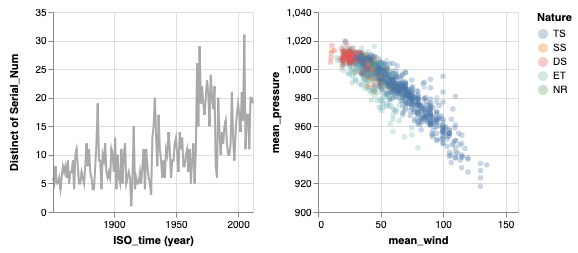

In [4]:
interval = alt.selection_interval(encodings=['x'],fields=['ISO_time:T'])

timeline = alt.Chart(tracts).mark_line().encode(
    x=alt.X('ISO_time:T', timeUnit='year'),
    y='distinct(Serial_Num):Q',
    color=alt.value('darkgray')
).properties(
    selection=interval,
    width=200,
    height=200
)
# 
scatter = alt.Chart(tracts).mark_circle(opacity=0.3).encode(
    x=alt.X('mean_wind:Q', scale=alt.Scale(domain=(0,150))),
    y=alt.Y('mean_pressure:Q', scale=alt.Scale(domain=(900,1040))),
    color=alt.Color('Nature:N', scale=alt.Scale(domain=('TS','SS','DS','ET','NR')))
).transform_filter(
    {'and': [
        alt.FieldGTPredicate(field='Pressure in millibars', gt=0),
        alt.NamedSelection(interval.ref())
            ]
    } 
).transform_aggregate(
    mean_wind='mean(Wind in knots)',
    mean_pressure='mean(Pressure in millibars)',
    groupby=['Serial_Num','Nature']
).properties(
    width=200,
    height=200
)

timeline | scatter

In [5]:
# If you have vega_datasets installed

# from vega_datasets import data
# states = alt.topo_feature(data.us_10m.url, feature='states')


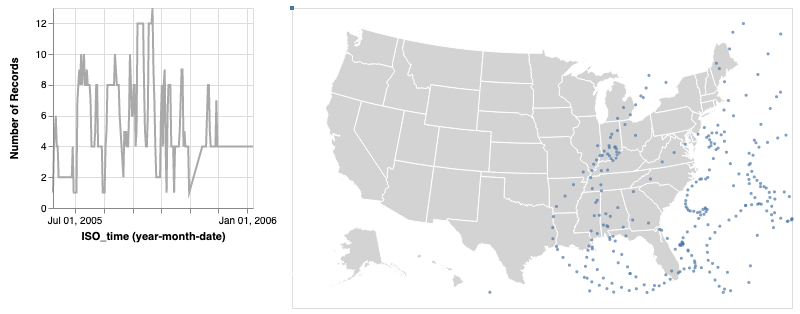

In [6]:
states = alt.topo_feature('https://vega.github.io/vega-datasets/data/us-10m.json', 'states')

interval = alt.selection_interval(encodings=['x'],fields=['ISO_time:T'])

timeline = alt.Chart(tracts).mark_line().encode(
    x=alt.X('ISO_time:T', timeUnit='yearmonthdate'),
    y='count():Q',
    color=alt.value('darkgray')
).transform_filter(
    "datum.Season == 2005"
).properties(
    selection=interval,
    width=200,
    height=200
)

background = alt.Chart(states).mark_geoshape(
    fill='lightgray',
    stroke='white'
).project('albersUsa').properties(
    width=500,
    height=300
)

points = alt.Chart(tracts).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.value(10),
    tooltip='Hurricane Name'
).transform_filter(
    {'and': [
        alt.FieldEqualPredicate(field='Season', equal="2005"),
        alt.NamedSelection(interval.ref())
            ]
    } 
).project(
    "albersUsa"
).properties(
    width=500,
    height=400
)

timeline | (background + points)